In [2]:
"""
import xml.etree.ElementTree as ET
tree = ET.parse('NCBI_API_key.xml')
root = tree.getroot()
api_key = root[0].text
"""

api_key = "47fe83f235e7f1024db4886646648fa28508"

In [26]:
from time import sleep
import xml.etree.ElementTree as ET
import sys  # all I need is sys.stdout
import requests

baseurl = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/'
retmax = 10 # PMIDs listed; default is 20
mode = 'retmode=xml' # esearch.fcgi appends this by default
# headers={'x-api-key':'09ba90f6-dcd0-42c0-8c13-5baa6f2377d0'}
# resp = requests.get(url,headers=headers)

databases = ["pubmed", "pmc"]
ancient = 1800
startyear = 1940
# endyear = 2025
endyear = 2021


def print_line(year, database_list, outfile=sys.stdout):
    errormsg = ''
    line = str(year)
    for db in database_list:
        if db == "pubmed":
            baseterm = '(%22tic+disorders%22[mesh]+or+tourette[tw]+not+tourette%2A[au])+and+'
        elif db == "pmc":
            baseterm = '(%22tic+disorders%22[mesh]+or+tourette[ti]+or+tourette[ab]+or+tourette[kwd]+not+tourette%2A[au])+and+'
            # [tw] in PMC includes _the entire article text, including references!_
        else:
            assert False, "unknown database specified"  
        if year == 'pre-'+str(startyear):
            term = baseterm + str(ancient) + ':' + str(startyear-1) + '[pdat]'
        else:
            term = baseterm + str(year)+'[pdat]+not+'+str(ancient)+'[pdat]:'+str(year-1)+'[pdat]'
        url = baseurl+'esearch.fcgi'+'?db='+db+'&api_key='+api_key+'&term='+term 
        resp = requests.get(url)
        sleep(0.100) # seconds, because I'm not supposed to query more than 10 times a second 
        check = resp.status_code
        if check != 200:
            errormsg = 'CAREFUL, request status code =' + check
        root = ET.fromstring(resp.content)
        line = line + ',' + root.find('Count').text
    line = line + ',' + errormsg
    print(line, file=outfile)

"""
print("year,pubmed,pmc,errors")
print_line('pre-'+str(startyear), databases)
for year in range(startyear,endyear+1):
    print_line(year, databases)
"""

RELOAD_FROM_NCBI = True

if RELOAD_FROM_NCBI:
    with open('TS_publications_20220601.csv', 'w') as f:
        print("year,pubmed,pmc,errors", file=f)
        print_line('pre-'+str(startyear), databases, outfile=f)
        for year in range(startyear,endyear+1):
            print_line(year, databases, outfile=f)

## Warning

PMC says the following about the [tw] qualifier:

"Text Word [tw] or [Text Word]

Includes all words and numbers in the title, abstract **and article body**, as well as in table and figure captions **and in the article reference section**." [ref](https://ncbi.nlm.nih.gov/pmc/about/userguide/#tw)  So for a 2021 search on 01 Jun 2022, including "tourette[tw]" returns >800 articles. 

Maybe it would be better to search PMC instead for "tourette[ti]+or+tourette[ab]+or+tourette[kwd]" (I'm not sure what "key terms in the body" means, but including these 3 for 2021 give 257 articles, and omitting the [kwd] produces only 125. For comparison, the [tw] search in PubMed gives 300 results). There is no [tiab] in PMC. **NOTE,** 257 is the # returned both by equery's "Count" and in the PMC search window.

* **Title [ti]** Words and numbers included in the title of an article.
* **Abstract [ab]** Includes all words and numbers in the abstract of an article. English language abstracts are taken directly from the published article. If an article does not have a published abstract, PMC does not create one.
* **Article Body - Key Terms [kwd]** Includes all key terms in the body of an article except for the Abstract and References.
* **Electronic Publication Date [epubdate]** The date of the electronic publication. Dates or date ranges must be entered using the format YYYY/MM/DD [epubdate] (e.g., 2021/04/06 [epubdate]). The month and day are optional (e.g., 2021 [epubdate] or 2021/03 [epubdate]). To enter a date range, insert a colon (:) between the dates (e.g., 2020:2021 [epubdate] or 2021/01:2021/04 [epubdate]).
* **Entrez Date [edat]** The date the article was added to the PMC database. Search results are displayed in Entrez Date order, i.e., last in, first out.
* **Publication Date [pubdate]** Tip: The display of the publication date depends on the publication format of the journal (e.g., electronic, print). Some journals include just the year, whereas others include the year plus month or year plus month plus day. Some journals use the year and season (e.g., Winter 2021). The publication date in the citation is recorded as it is provided to PMC from the publisher. It is recommended that you search only by year (e.g., "2021[pubdate]" or "2019:2021[pubdate]").

Note, PubMed now uses only [ti] and [tiab] fields (no [ab]). Searches for 2021:
* (tourette[tw] NOT tourette[tiab] NOT tourette[au]) -> 7 entries.
* (tourette[tiab] NOT tourette[tw] NOT tourette[au]) -> 0 entries, *i.e.* it appears that [tiab] is a subset of [tw].
* (tourette[tiab] OR tourette[tw] NOT tourette[au]) -> 280 entries
* ("tic disorders"[mesh] OR tourette[tiab] OR tourette[tw] NOT tourette[au]) -> 300 entries
* ("tic disorders"[mesh] OR tourette[tw] NOT tourette[au]) -> 300 entries
* (tourette[tw] NOT tourette[au]) -> 280 entries
* ("tic disorders"[mesh] NOT tourette[tiab] NOT tourette[tw] NOT tourette[au]) -> 20 entries. 

OK, but **weird**, those are the numbers from typing the text in the window of a PubMed search box. The return from the eutils equery for ("tic disorders"[mesh] OR tourette[tw] NOT tourette[au]) is Count = 275 rather than 300. 

In [27]:
import numpy as np
import csv
with open('TS_publications_20220601.csv', 'rb') as datafile:
    data = np.recfromcsv(datafile, names=True, dtype=int)
years  = data['year'][1:]
pubmed = data['pubmed'][1:]
pmc    = data['pmc'][1:]

In [28]:
import statsmodels.api as sm
b = sm.nonparametric.lowess(pubmed,years,frac=1./3)
c = sm.nonparametric.lowess(pmc,   years,frac=1./3)

import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

In [29]:
# Named colors are shown here: https://matplotlib.org/3.3.1/gallery/color/named_colors.html
# Other colors (e.g. xkcd survey colors) are here: https://matplotlib.org/3.3.1/tutorials/colors/colors.html

f1000research_color=tuple([value/255.0 for value in (203,97,45)])
f1000research_h1   =tuple([value/255.0 for value in (55,67,76)])
f1000research_h1a  =tuple([value/255.0 for value in (208,222,233)]) # same as _h1 but much lighter
f1000research_h2   =tuple([value/255.0 for value in (33,97,128)])

"""
Colors for Faculty Reviews:
RGB (0-255) = 
"""
fac_rev_color = tuple([value/100.0 for value in (81.2, 21.6, 22.4)]) # logo and references
fac_rev_c2    = tuple([value/100.0 for value in (23.5, 32.2, 37.3)]) # journal name text
fac_rev_c3    = tuple([value/100.0 for value in (21.6, 30.6, 34.9)]) # section headings
fac_rev_c4    = tuple([value/100.0 for value in ( 0.0, 41.6, 54.1)]) # subsection headings
fac_rev_c5    = tuple([value/100.0 for value in (74.9, 78.4, 83.5)]) # table header row
fac_rev_c6    = tuple([value/100.0 for value in (90.6, 91.4, 93.7)]) # table shading
fac_rev_c7    = tuple([value/100.0 for value in (83.9, 86.3, 89.0)]) # table lines
fac_rev_c8    = tuple([value/255.0 for value in (229.5, 22.9, 25.7)]) 
    # logo and references color, but brighter (HSV: H still = 359.2, but S = V = 90)

#                         ( facecolor, scatterplot point color, LOESS line color)
colorset_f1000research  = (f1000research_h1a, 'black', f1000research_color)
colorset_fac_rev        = (fac_rev_c6, fac_rev_c2, fac_rev_color)

# colorset = colorset_fac_rev
colorset = colorset_f1000research

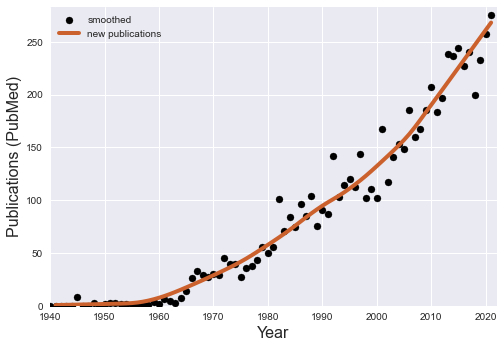

In [34]:
plt.clf()
plt.style.use('seaborn') 
ax = plt.gca()
# ax.set_facecolor(colorset[0]) # OR e.g. 'lavenderblush' 
plt.scatter(years,pubmed,color=colorset[1]) # OR color='black'
plt.plot(b[1:,0],b[1:,1],color=colorset[2],linewidth=4) # OR color=fac_rev_c8, for a brighter LOESS curve
# plt.plot(years,pmc,color='red') # PMC graph (not PubMed)
plt.axis((years[0],1+years[-1],0,8+pubmed.max()))
# plt.axis((years[0],1+years[-1],0,8+pmc.max())) # PMC graph (not PubMed)
plt.xlabel('Year',fontsize=16)
plt.ylabel('Publications (PubMed)',fontsize=16)
plt.legend(['smoothed','new publications'], loc='upper left')
plt.legend(['smoothed','new publications', 'new PMC publications'], loc='upper left')
# plt.savefig('TS_publications_2021.png', dpi=600, transparent=True) # only works with a clear background (duh)
plt.savefig('TS_publications_2021.png', dpi=600, transparent=True) 
plt.savefig('TS_publications_2021b.png', dpi=600)
plt.show()
